In [1]:
import sys
import os

package_path = os.path.join(os.getcwd(), "packages/")
if package_path not in sys.path:
    sys.path.insert(0, package_path)

import PubChemHazardAPI
import PubChemBioactivityAPI
import PubChemIdentifiers
import PubMedAPI
import AssayData
import ChemblAPI
import CTXAPI

import LLMAnalysis # this involves loading a huggingface model (BioGPT-Large) so expect the import block to take a little while - also expect some loading bars. If it's bugging you just comment it out
                   # I will point out the single block that uses it later

from tqdm import tqdm
import time
import json

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv


Stepping into a role as a risk-concerned toxicologist conducting a preliminary analysis of the potential hazard posed by some chemical. It could be interesting to look at atrazine, a very common pesticide.

In [2]:
print(os.getcwd())

C:\Users\Nate\Documents\Projects\2025\ChemicalToxAnalysis


In [3]:
CHEMICAL_NAME = 'atrazine'

load_dotenv()
CTX_API_KEY = os.getenv("CTX_API_KEY")
if not CTX_API_KEY:
    raise ValueError("API key not found. Please set CTX_API_KEY in your .env file.")

In [4]:
inchi_key = PubChemIdentifiers.inchi_from_name(CHEMICAL_NAME)
# I don't generally trust preferred names so I'm going to convert to Inchi for tracking purposes. In a production environment we would need to be careful in how we map preferred name to Inchikey
# Confining scope to handling compounds. Substances would require more upstream handling/thinking
pubchem_cid = PubChemIdentifiers.pubchem_cid_from_inchi(inchi_key)

In [5]:
assays = PubChemBioactivityAPI.pubchem_bioactivity_summary(pubchem_cid)
bioactivity_summary = PubChemBioactivityAPI.bioactivity_json_to_dframe(assays)
bioactivity_summary = bioactivity_summary.loc[bioactivity_summary['Activity Outcome'] == 'Active']

try: 
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "r") as fin:
        tox_assays = json.load(fin)
except:
    print("No JSON detected. Analyzing assays.")
    tox_assays = {}
    for aid in tqdm(bioactivity_summary['AID'], desc="Detecting Relevant Assays"):
        assay_desc = PubChemBioactivityAPI.assay_description(aid)
        relevance = AssayData.tox_keyword_hits(assay_desc)
        if relevance != None:
            tox_assays[aid] = {"keywords" : relevance, "desc" : assay_desc}
        # avoid angering pubchem gods - stick to < 5 requests / sec
        time.sleep(0.21)
    with open(os.path.join(os.getcwd(), f"assay_desc_{pubchem_cid}.json"), "w") as fout:
        json.dump(tox_assays, fout, indent=2)

BA_summary = AssayData.summarize_assay_data(tox_assays)
GHS_summary = PubChemHazardAPI.summarize_hazard_codes(PubChemHazardAPI.extract_ghs_hazard_codes(pubchem_cid))

print(BA_summary)
print(GHS_summary['GHS Definitions'])


{'developmental': 1, 'mutagen': 2, 'CYP': 3}
['Harmful if swallowed Acute toxicity, oral', 'May cause an allergic skin reaction Skin sensitization', 'Causes serious eye irritation Serious eye damage/eye irritation', 'Causes eye irritation Serious eye damage/eye irritation', 'May be harmful if inhaled Acute toxicity, inhalation', 'Suspected of damaging fertility or the unborn child Reproductive toxicity', 'May cause damage to organs Specific target organ toxicity, single exposure', 'May cause damage to organs through prolonged or repeated exposure Specific target organ toxicity, repeated exposure', 'Very toxic to aquatic life Hazardous to the aquatic environment, acute hazard', 'Very toxic to aquatic life with long lasting effects Hazardous to the aquatic environment, long-term hazard']


Extensive hazard code profile and activity in bioassays associated with CYP metabolism/activity, mutagens, and one developmental assay. It's enough that I'd want to pull up the abstracts and check how many of these indicate a true issue. The ecotox is noticeable. In a fully automated setting invoking an LLM would be an option here. Ideally one of the good ones (though the API costs can stack up).

In [6]:
tox_assays['1259392'] # pulling the 'developmental' record by its AID. It looks like activity in this assay might represent a genuine devtox concern, but it's hardly an in vivo study

{'keywords': ['developmental'],
 'desc': ['U.S. Tox21 Program',
  '',
  'National Center for Advancing Translational Sciences [NCATS]',
  'NIH Chemical Genomics Center [NCGC]',
  'U.S. Environmental Protection Agency [EPA]',
  'National Institutes of Environmental Health Sciences [NIEHS]',
  'National Toxicology Program [NTP]',
  'U.S. Food and Drug Administration [FDA]',
  '',
  'Tox21 Assay Overview:',
  '',
  'The sonic hedgehog (Shh) pathway is essential for normal embryonic development. Dysregulation of the Shh pathway can cause severe developmental defects in organs. Therefore chemicals that interfere with the pathway are potential developmental toxicants. A cell line designated 3T3Gli1-Luc (DMB/OARSA/CFSAN/FDA, Laurel, MD), a NIH/3T3 derived clone containing stably integrated Gli1-Luc reporter is used to detect chemical interference of the Shh pathway, by changes in the expression of the firefly Luc gene under the control of the Gli1 transcriptional response element. This cell l

In the context of further investigating the toxicology of this molecule I would also be interested in the scientific literature. We can programmatically access them using the PubMed APIs. We can grab ten articles from that passed year that referenced the chemical, atrazine, and the keyword 'toxicity'.

In [7]:
pmids = PubMedAPI.get_pubmed_ids(CHEMICAL_NAME)
first_abstract = PubMedAPI.get_abstract(pmids[0])
print(first_abstract)

1. ACS Omega. 2025 Mar 15;10(11):11264-11273. doi: 10.1021/acsomega.4c10903. 
eCollection 2025 Mar 25.

Aquatic Macrophytes in the Remediation of Atrazine in Water: A Study on 
Herbicide Tolerance and Degradation Using Eichhornia crassipes, Pistia 
stratiotes, and Salvinia minima.

Ramírez Hernandez MC(1), Nogueira Bandeira J(1), Rosero Alpala DA(1), Pacheco 
Batista L(1), Silvestre Araújo MA(1), das Chagas PSF(1), Valadao Silva D(1), 
Costa de Morais ER(2).

Author information:
(1)Department of Agronomic and Forest Sciences, Federal University of the 
Semiarid-UFERSA, AV. Francisco Mota, 572 - Pres. Costa E Silva, RN, Mossoró, 
59625-900 Rio Grande do Norte, Brazil.
(2)Engineering Center, Federal University of the Semiarid-UFERSA, AV. Francisco 
Mota, 572 - Pres. Costa E Silva, RN, Mossoró, 59625-900 Rio Grande do Norte, 
Brazil.

Aquatic macrophytes can be used for herbicide remediation provided they exhibit 
tolerance to the contaminants. This research assessed the remediation poten

Personally I have no issue reading the literature, but I recognize the point of this exercise is to be considering an agentic system. With this in mind I wanted to explore the utility of an LLM for getting simplied but representative summaries of the abstracts recovered from pubmed. Please note: this method is rough. I think there's promise but it requires work out of scope of this assignment, and more careful validation the LLM is consistently delivering a reliable summary. It looked decent for the few examples I eyeballed, but that's not exactly exhaustive.

This function downloads and runs BioGPT-Large from HuggingFace so it will be memory and processor hungry. In a perfect world I'd have an api key to more advanced models, but they charge a corporate rate.

*If you commented out the LLM import earlier this block will not work*

In [ ]:
LLMAnalysis.key_finding(first_abstract)

Pulling available data for looking at ADME properties could be insightful.

In [8]:
chembl_id = ChemblAPI.chemblid_from_inchi(inchi_key)
assay_type = 'A'
organism = 'Homo sapiens'
types = ['log Kp', 'F', 'Vd', 'CL'] # logKp for skin permeability, F for bioavailability, Vd for volume of distribution, CL for clearance - this should give a good overview of expected ADME if there's data

adme_assays = ChemblAPI.chembl_ADME(chembl_id, organism)
clean_adme = ChemblAPI.clean_ADME(adme_assays, types)
clean_adme

,assay_chembl_id,assay_description,bao_endpoint,target_organism,target_pref_name,type,units,value
0,CHEMBL865441,Permeability in human skin,BAO_0000179,Homo sapiens,Homo sapiens,log Kp,cm/s,-5.56
3,CHEMBL925052,Permeability across human Skin,BAO_0000179,Homo sapiens,Skin,log Kp,None,-5.56


Skin permeability looks to be relatively low for this compound. That's good for something that's not intended for topical administration. It can't do damage if it doesn't get into the body.

In [9]:
ChemblAPI.chembl_tox(chembl_id)

[]

In [10]:
CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY)

'DTXSID9020112'

In [11]:
dtxsid = CTXAPI.get_dtxsid_from_inchikey(inchi_key, CTX_API_KEY) # the DTXSID is the core chemical identifier for most USEPA systems
cancer_data = CTXAPI.get_cancer_data(dtxsid, CTX_API_KEY)
print(cancer_data)

[{'id': 2680, 'source': 'EPA OPP', 'url': 'http://www.epa.gov/pesticides/carlist/', 'exposureRoute': '-', 'cancerCall': 'Not Likely to Be Carcinogenic in Humans', 'dtxsid': 'DTXSID9020112'}, {'id': 2681, 'source': 'IARC', 'url': 'https://monographs.iarc.who.int/list-of-classifications/', 'exposureRoute': '-', 'cancerCall': 'Group 3 - Not classifiable as to its carcinogenicity to humans', 'dtxsid': 'DTXSID9020112'}]


In [12]:
ctx_hazard = CTXAPI.get_hazard_data(dtxsid, CTX_API_KEY)
len(ctx_hazard)
pd.DataFrame(ctx_hazard).columns

Index(['id', 'year', 'source', 'priorityId', 'subsource', 'sourceUrl',
       'subsourceUrl', 'riskAssessmentClass', 'toxvalType', 'toxvalSubtype',
       'toxvalNumeric', 'toxvalNumericQualifier', 'toxvalUnits', 'studyType',
       'studyDurationClass', 'studyDurationValue', 'studyDurationUnits',
       'strain', 'sex', 'population', 'exposureMethod', 'exposureForm',
       'media', 'lifestage', 'generation', 'criticalEffect', 'detailText',
       'supercategory', 'speciesCommon', 'humanEcoNt', 'exposureRoute',
       'dtxsid'],
      dtype='object')

In [13]:
noncancer_hazard = pd.DataFrame(ctx_hazard)[['id', 'source', 'subsource', 'sourceUrl', 'riskAssessmentClass', 'toxvalType', 'toxvalNumeric', 'toxvalUnits', 'criticalEffect', 'speciesCommon', 'exposureRoute']]

To harmonize and aggregate the toxicology data for this compound into a consolidated benchmark human equivalent dose I'm going to use a technique that only a few folks, mostly EPA-internal, will know about. It is technically documented to the public but is *not* an official assessment product. I am using it because it's a beautiful way to bring together disparate toxicity data into a single summary number. I am happy to to speak about it more. The public *draft* of the method is available at https://www.epa.gov/system/files/documents/2024-12/dcap-report_bosc-review_508-compliant_final.pdf and is in the process of undergoing scientific panel review.

I will be using it to consolidate the information in the chronic, sub-chronic, and acute (short-term) studies. I'm also using a somewhat simplified version for the sake of brevity in this exercise.

In [14]:
df = noncancer_hazard.query(
    "source == 'ToxRefDB' and ((riskAssessmentClass == 'subchronic') or (riskAssessmentClass == 'chronic') or (riskAssessmentClass == 'short-term')) and ((toxvalType == 'NOAEL') or (toxvalType == 'LOAEL'))"
)

In [15]:
# See Table 4-1 of documentation

duration_cf = {
    'chronic' : 1, 
    'subchronic' : (1/3), 
    'short-term' : (1/10)
}

species_cf = {
    "Mouse": (1/11.3),
    "Rat": (1/5.6),
    "Rabbit": (1/3.),
    "Dog": (1/1.7),
}

effectlevel_cf = {
    "LOAEL" : (1/3),
    "NOAEL" : 1,
}

In [16]:
df.to_csv(os.path.join(os.getcwd(), "tox_df.csv"))

In [17]:
import numpy as np

def compute_eBMDHED(row):
    duration = 1 if row["riskAssessmentClass"] == "developmental" else duration_cf.get(row["toxvalType"].lower(), 1)
    species = species_cf.get(row["speciesCommon"], 1)
    study = effectlevel_cf.get(row["toxvalType"], 1)
    return row["toxvalNumeric"] * study * species * duration

df.loc[:, "eBMDHED_mg_kg_day"] = df.apply(compute_eBMDHED, axis=1)
df['Log(BMDHED)'] = np.log10(df['eBMDHED_mg_kg_day'])


C:\Users\Nate\AppData\Local\Temp\ipykernel_26824\710382916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "eBMDHED_mg_kg_day"] = df.apply(compute_eBMDHED, axis=1)
C:\Users\Nate\AppData\Local\Temp\ipykernel_26824\710382916.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log(BMDHED)'] = np.log10(df['eBMDHED_mg_kg_day'])


In [18]:
lower_ci = df['Log(BMDHED)'].quantile(0.025)
upper_ci = df['Log(BMDHED)'].quantile(0.975)

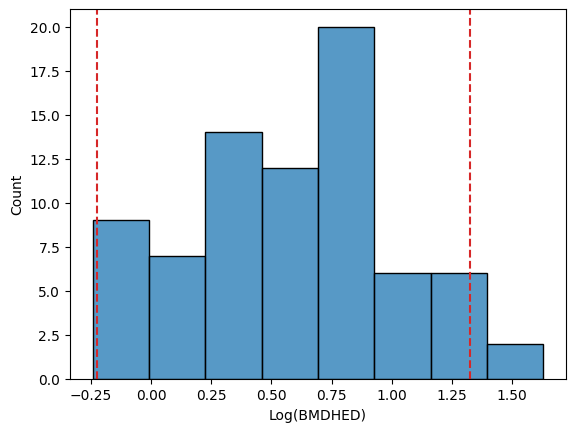

In [19]:
fig, ax = plt.subplots()
sns.histplot(df, x='Log(BMDHED)')
ax.axvline(lower_ci, linestyle="--", c="tab:red")
ax.axvline(upper_ci, linestyle="--", c="tab:red")
plt.show()

In [20]:
float(10**lower_ci)

0.5955310008217203

In [21]:
df = noncancer_hazard.query(
    "toxvalType == 'RfD'"
)

In [22]:
df

,id,source,subsource,sourceUrl,riskAssessmentClass,toxvalType,toxvalNumeric,toxvalUnits,criticalEffect,speciesCommon,exposureRoute
7497,378472,Cal OEHHA,California DPH,https://oehha.ca.gov/chemicals,chronic,RfD,0.006,mg/kg-day,-,Human (RA),oral
7522,377757,HEAST,-,https://cfpub.epa.gov/ncea/risk/recordisplay.c...,chronic,RfD,0.035,mg/kg-day,reduced weight gain,Human (RA),oral
7524,383868,IRIS,-,https://www.epa.gov/iris,chronic,RfD,0.035,mg/kg-day,Other:Decreased body weight gain,Human (RA),oral
7527,393612,OW Drinking Water Standards,EPA OW,https://www.epa.gov/ground-water-and-drinking-...,chronic,RfD,0.020,mg/kg-day,-,Human (RA),oral
7536,377640,Pennsylvania DEP ToxValues,Health Effects Assessment Summary Table (HEAST),https://www.dep.state.pa.us/toxicity/ToxicityV...,chronic,RfD,0.035,mg/kg-day,-,Human (RA),-
7540,378430,RSL,ATSDR,https://www.epa.gov/risk/regional-screening-le...,chronic,RfD,0.003,mg/kg-day,-,Human (RA),-
7543,391888,RSL,ATSDR,https://www.epa.gov/risk/regional-screening-le...,chronic,RfD,0.003,mg/kg-day,-,Human (RA),oral
